## <center style="color:red;">**BrainScan – Détection du Cancer Cérébral par CNN**</center>

<br>

### <span style="color:green;">**Conception du Modèle CNN :**</span>

#### <span style="color:blue;">**1. Définir l’architecture du modèle CNN :**</span>

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.utils import plot_model
import time
import joblib as jbl

variables = jbl.load("../util/variables.pkl")

X_train = variables["X_train"]
y_train = variables["y_train"]
X_test = variables["X_test"]
y_test = variables["y_test"]
images = variables["images"]
labels = variables["labels"]

print("Variables importées avec succès !")

Variables importées avec succès !


**Créer le modèle avec des couches Conv2D, MaxPooling, Dropout, Dense :**

In [6]:

model = models.Sequential([
    Input(shape=(224, 224, 3)),
    # Couche 1 : Convolution + ReLU + MaxPooling
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Couche 2 : Convolution + ReLU + MaxPooling
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Couche 3 : Convolution + ReLU + MaxPooling
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Dropout pour éviter le surapprentissage
    layers.Dropout(0.3),
    
    # Couche Flatten pour aplatir les cartes de caractéristiques
    layers.Flatten(),
    
    # Couche Dense cachée
    layers.Dense(128, activation='relu'),
    
    # Dropout supplémentaire
    layers.Dropout(0.3),
    
    # Couche de sortie (nombre de neurones = nombre de classes)
    layers.Dense(y_train.shape[1], activation='softmax')  # Softmax pour classification multi-classes
])

**Afficher l’architecture du modèle avec model.summary() et plot_model() :**

In [7]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

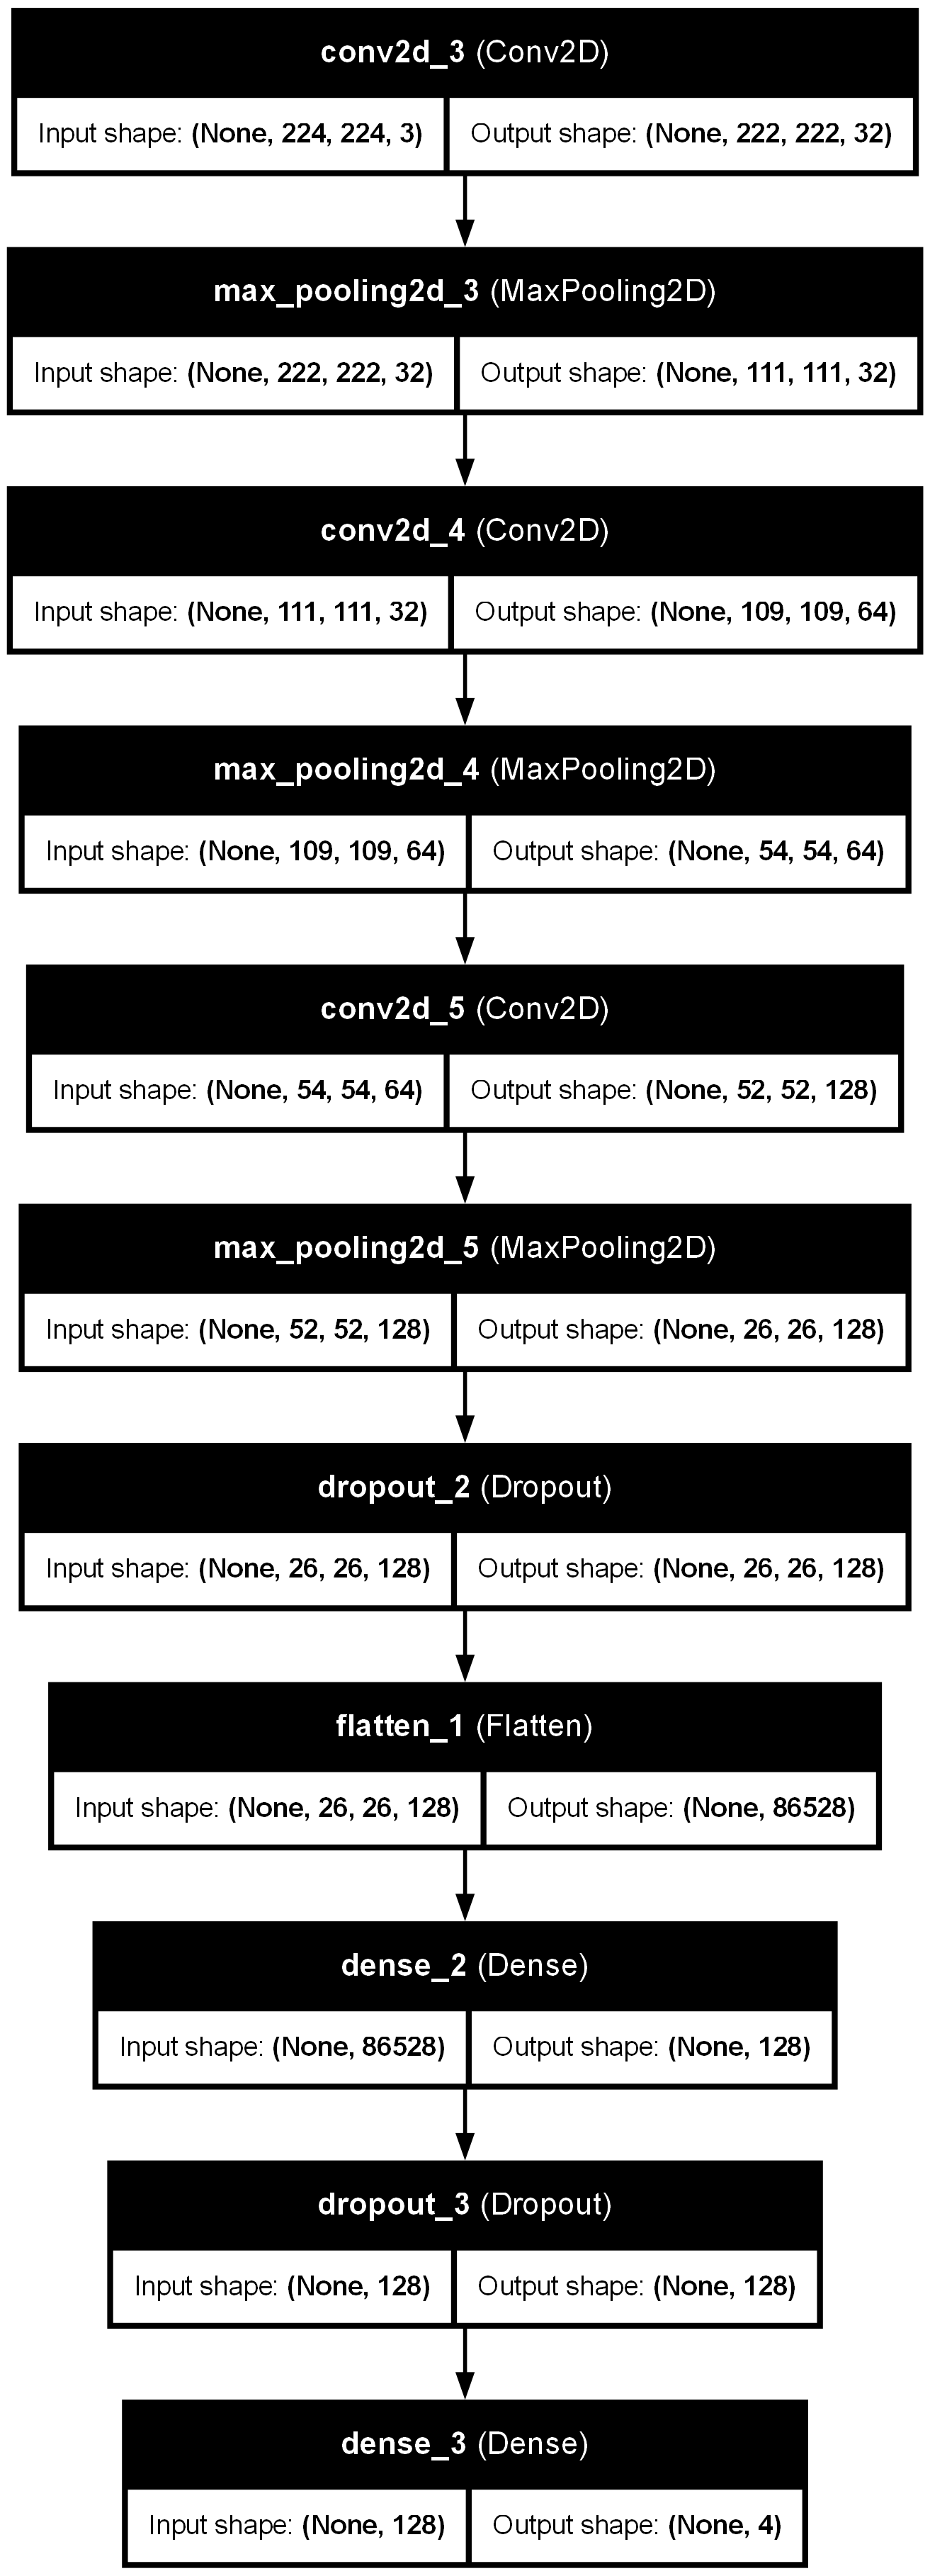

In [8]:
from tensorflow.keras.utils import plot_model

plot_model(
    model,
    to_file="../cnn_model_architecture.png",
    show_shapes=True,
    show_layer_names=True
)

#### <span style="color:blue;">**2. Optimiser la compilation du modèle :**</span>